In [1]:
from refine import *
import project
import time
import prody as pdy
import matplotlib.pyplot as plt

%pylab inline
project.setup()

Populating the interactive namespace from numpy and matplotlib


/home/semyon/mipt/GPCR-TEAM/env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['bar', 'tanh', 'sin', 'tan', 'radians', 'sinh', 'norm', 'dot', 'bytes', 'degrees', 'sum', 'cos', 'sqrt', 'byte', 'cosh']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def distance(A, B):
    darr = []
    for i in range(len(A)):
        for j in range(len(B)):
            diff = A[i] - B[j]
            darr.append(np.linalg.norm(diff))
    darr = np.array(darr)
    return np.min(darr)

In [3]:
path = str((project.data_path / "may_complex") / "1dfj.pdb")
print(path)
create_system(path, tmp_file=str(project.output_path / "tmp_system.pdb"))
t0 = time.time()
pc = ProteinComplex(str(project.output_path / "tmp_system.pdb"), "charmm36.xml", ["chain A", "chain B"])
print("construction of system:", -t0 + time.time(), "sec")

@> 4416 atoms and 1 coordinate set(s) were parsed in 0.05s.


/home/semyon/PycharmProjects/DiplomaPython/data/may_complex/1dfj.pdb
write PDB(prody): 0.0323 sec
read PDB(openmm): 0.3129301071166992 sec


@> 8726 atoms and 1 coordinate set(s) were parsed in 0.06s.


add hydrogens and extra particles(openmm): 20.076255559921265 sec
write PDB(openmm): 0.09058952331542969 sec
construction of system: 9.949674606323242 sec


In [4]:
coords_0 = pc.get_coords(0)
coords_1 = pc.get_coords(1)

In [5]:
pc.set_coords(0, coords_0)
pc.set_coords(1, coords_1)

In [6]:
t0 = time.time()
mode_params = [
    {"nmodes": 10, "cutoff": 4.0},
    {"nmodes": 0}
]
rw = RMRestrictionWrapper(pc, mode_params)
print("construction of wrapper:", -t0 + time.time(), "sec")

@> Hessian was built in 0.62s.
@> 10 modes were calculated in 15.02s.


construction of wrapper: 15.662909030914307 sec


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


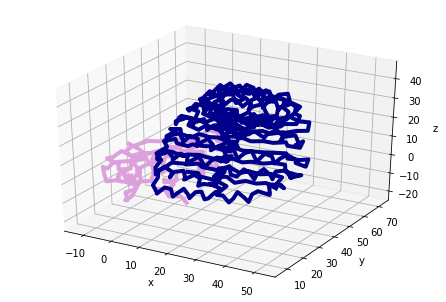

In [7]:
rw.set_position(0, [np.array([0, 0, 0]), np.quaternion(1, 0, 0, 0), np.array([0] * 10)])
pdy.showProtein(rw._protein_complex._pdy_protein)
pylab.show()

In [8]:
# господин никто
# awakenings
# chernobl series
t0 = time.time()
E = rw.get_energy()
t1 = time.time() - t0
print(f"energy calculated in {t1} seconds")

energy calculated in 3.3034474849700928 seconds


In [9]:
print(rw.get_position(0))

[array([0, 0, 0]), quaternion(1, 0, 0, 0), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


In [16]:
pos0 = rw.get_position(0)
pos1 = rw.get_position(1)
rw.set_position(0, [np.array([0, 0, 0]), np.quaternion(np.cos(np.pi * (0)), 0, np.sin(np.pi * (0)), 0), (len(coords_0)) ** 0.5 * np.array([4, *([0] * 9)])])
rw.set_position(1, [np.array([0, 0, 0]), pos1[1], pos1[2]])

[[ 5.63114844 -8.82008613  1.4165008 ]
 [ 6.51056972 -9.12153053  0.61139007]
 [ 5.13845231 -8.20506772  1.16026866]
 ...
 [ 2.09219596  1.15669154  1.03740019]
 [ 2.0081735   1.70379575  0.93847736]
 [ 1.36989812  0.71096252  0.6628012 ]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


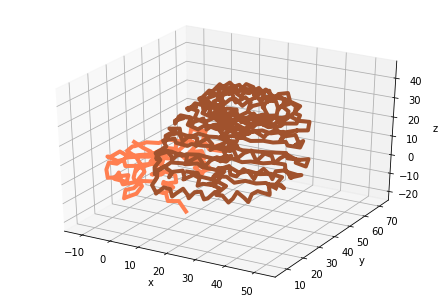

In [17]:
pdy.showProtein(rw._protein_complex._pdy_protein)
pylab.show()

In [18]:
n = len(coords_0)
rotation_matrix = np.identity(3)
mode_pos = rw.get_position(0)[2]
print(mode_pos)
i_tensor = rw._i_tensors[0]
c_tensor = rw._c_tensors[0]
d_tensor = rw._d_tensors[0]
f_tensor = rw._f_tensors[0]
weights = rw._weights[0]
print(i_tensor)
new_i_dir = build_i_tensor(rw._protein_complex.get_coords(0), c_tensor, weights)
new_i_ind = calc_inertia_tensor(rotation_matrix, mode_pos, i_tensor, d_tensor, f_tensor, weights)
print(new_i_dir)
print(new_i_ind)
print(np.linalg.norm(new_i_dir - new_i_ind))

[172.32527383   0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
[[231566.87398189 -61627.08308905 -38752.33120476]
 [-61627.08308905 280608.59813923 -21823.42721913]
 [-38752.33120476 -21823.42721913 274621.92311142]]
[[245954.46693406 -24941.77469501 -27098.99341385]
 [-24941.77469501 245075.88345514 -10024.56989656]
 [-27098.99341385 -10024.56989656 263954.60435016]]
[[245954.46693407 -24941.774695   -27098.99341385]
 [-24941.774695   245075.88345513 -10024.56989657]
 [-27098.99341385 -10024.56989657 263954.60435017]]
2.4834302536348124e-08


In [19]:
c_tensor

array([ 5.35275808, 24.43508028,  6.60506627])

In [17]:
step = -3
T = np.array([step, 0, 0])

ref_coords = pc.get_coords(1)
old_coords = pc.get_coords(0)

n = len(old_coords)
T_span = np.tile(T, n).reshape((n, 3))


X = [0]
E = [pc.get_energy()]
D = [distance(old_coords, ref_coords)]
for i in range(15):
    new_coords = old_coords + T_span
    old_coords = new_coords
    pc.set_coords(0, new_coords)
    E.append(pc.get_energy())
    D.append(distance(old_coords, ref_coords))
    X.append(step * (i + 1))
    print(i + 1, end=" ")
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X, E)
ax.set_yscale("linear")
ax.grid()
plt.show()

In [19]:
E = np.array(E)

In [20]:
E1 = E - np.min(E) + 1

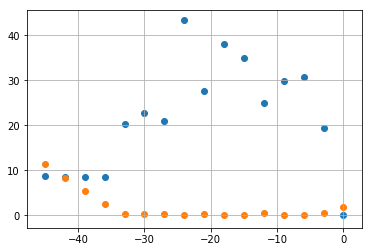

In [21]:
fig, ax = plt.subplots()
ax.scatter(X, np.log(E1))
ax.scatter(X, D)
ax.set_yscale("linear")
ax.grid()
plt.show()